# 데이터 준비

In [1]:
import scaling1
import scaling2
import scaling3
import scaling4

import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from utils import imbalance_plot, plot_roc_curve, confusion_matrix, plot_distribute
warnings.filterwarnings('ignore')
cf.go_offline(connected=True)
fold = 2

train = scaling4.load_data_using_multi_process(fold = fold, mode='train')
test = scaling4.load_data_using_multi_process(fold = fold, mode='test')
trainX=[]
trainY=[]

train_change=[]
test_change=[]

for row in train:
    if len(row[2:-1]) == 550:
        trainX.append(row[2:-1])
        trainY.append(int(row[-1] >= 0.05))
        train_change.append(row[-1])

testX=[]
testY=[]
date_code_lst =  []
for row in test:
    if len(row[2:-1]) == 550:
        date_code_lst.append(row[0:2])
        testX.append(row[2:-1])
        testY.append(int(row[-1] >= 0.05))
        test_change.append(row[-1])
    
train_change = np.array(train_change)
test_change = np.array(test_change)

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = np.array(testX)
testY = np.array(testY)

print(trainX.shape, testX.shape)

--- 31.49225664138794 seconds ---
--- 21.35482382774353 seconds ---
(81385, 550) (28430, 550)


권장 scale_pos_weight : 6.416841337829217


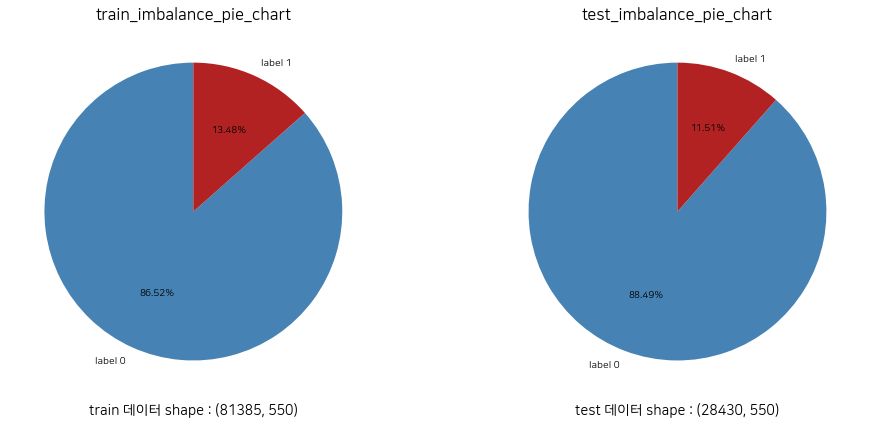

In [2]:
imbalance_plot( trainX, trainY, testX, testY)

In [3]:
12.77/87.23

0.14639458901753982

## parameter : scale_pos_weight

[5]	valid_0's auc: 0.619952	valid_0's binary_logloss: 0.658209
[10]	valid_0's auc: 0.62475	valid_0's binary_logloss: 0.636725
[15]	valid_0's auc: 0.628558	valid_0's binary_logloss: 0.624068
[20]	valid_0's auc: 0.632143	valid_0's binary_logloss: 0.61548
[25]	valid_0's auc: 0.635031	valid_0's binary_logloss: 0.609651
[30]	valid_0's auc: 0.636499	valid_0's binary_logloss: 0.6045
[35]	valid_0's auc: 0.637092	valid_0's binary_logloss: 0.601439
[40]	valid_0's auc: 0.637991	valid_0's binary_logloss: 0.597631
[45]	valid_0's auc: 0.639674	valid_0's binary_logloss: 0.594796
[50]	valid_0's auc: 0.639406	valid_0's binary_logloss: 0.592048
[55]	valid_0's auc: 0.639468	valid_0's binary_logloss: 0.590245
[60]	valid_0's auc: 0.640222	valid_0's binary_logloss: 0.58746
[65]	valid_0's auc: 0.640966	valid_0's binary_logloss: 0.585874
[70]	valid_0's auc: 0.639322	valid_0's binary_logloss: 0.583382
[75]	valid_0's auc: 0.639829	valid_0's binary_logloss: 0.581685
[80]	valid_0's auc: 0.640781	valid_0's binary_

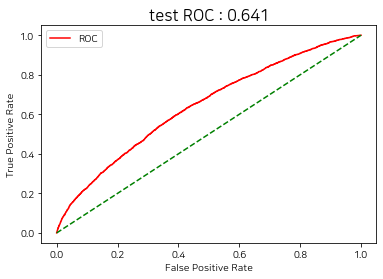

train_f1 score:  0.40006138735420504
test_f1 score:  0.2528231553557724 

train_recall score:  0.5939123302651964
test_recall score:  0.352491592785081 

train_pre score:  0.30161521729069285
test_pre score:  0.19709401709401708 

train acc score:  0.7598328930392578
test acc score:  0.7602884277172002 

     y_true
pred [1153, 4697] 
     [2118, 20462]
---1.8513414859771729 seconds ---


In [3]:
from lightgbm import LGBMClassifier
import os
import time

# pos 8.2 & lr 0.08하면 더 좋음

start_time=time.time()

model = LGBMClassifier(random_state = 42,
                       scale_pos_weight= 6.4,
                       learning_rate=0.1, 
                       num_iterations = 1000, # n_estimator 랑 같은 것 같음
                       max_depth = 4,
                       n_jobs= 30,
                       boost_from_average = False,
                       objective = 'binary')

trained_model = model.fit( trainX,trainY, 
          eval_set=[(testX,testY)],
          early_stopping_rounds=25, 
          verbose = 5,
          eval_metric = 'auc')

train_pred = trained_model.predict(trainX)
train_prob = trained_model.predict_proba(trainX)[:, 1]

test_pred = trained_model.predict(testX)
test_prob = trained_model.predict_proba(testX)[:, 1]

plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob)
confusion_matrix(testY, test_pred)
print("---%s seconds ---" % (time.time() - start_time))

## 확률 분포 확인하기
> 0.8 ~ 1 : distrib1   
> 0.6 ~ 0.8 : distrib2   
> 0.4 ~ 0.6 : distrib3   
> 0.2 ~ 0.4 : distrib4   
> 0 ~ 0.2 : distrib5   

평균 값: 0.0023146180238369893


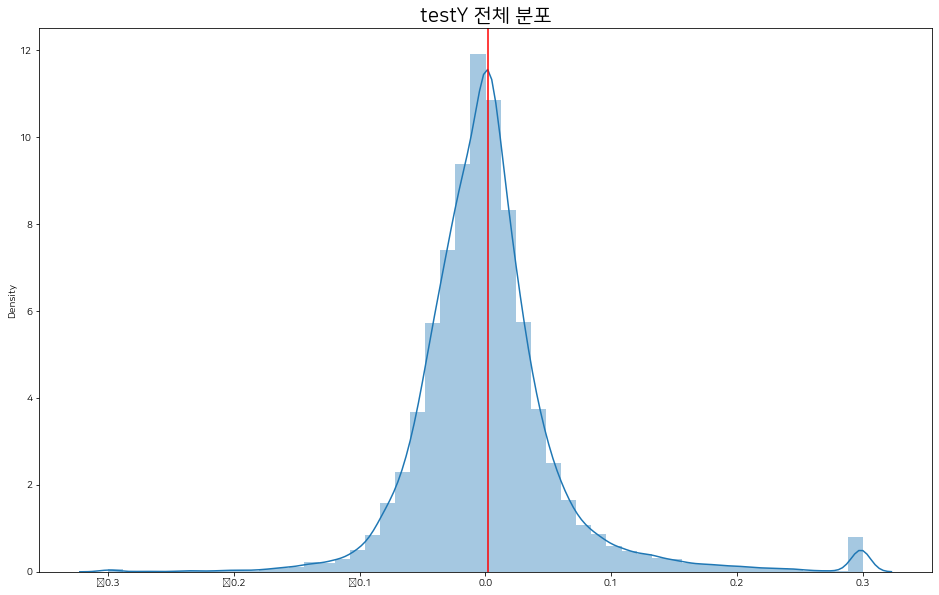

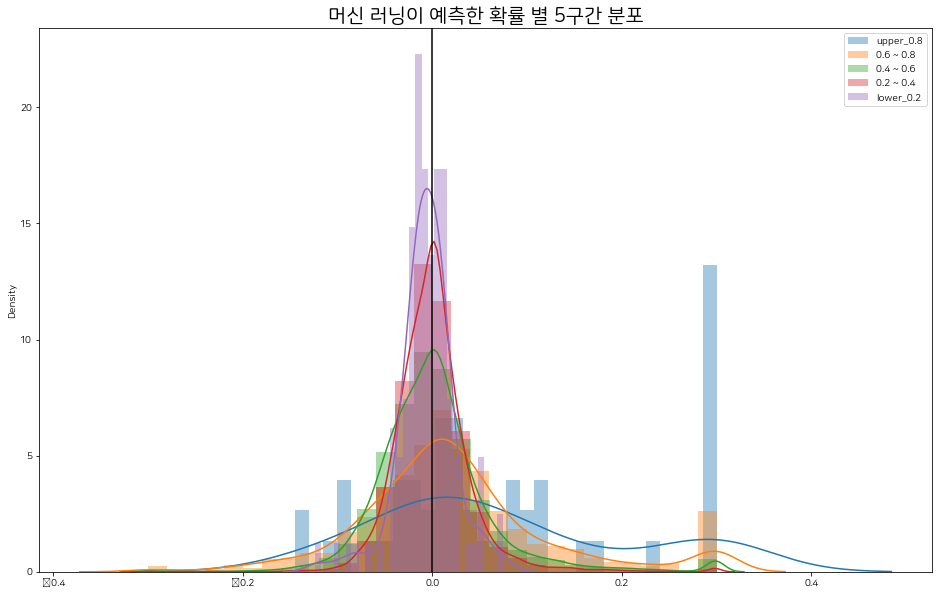

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


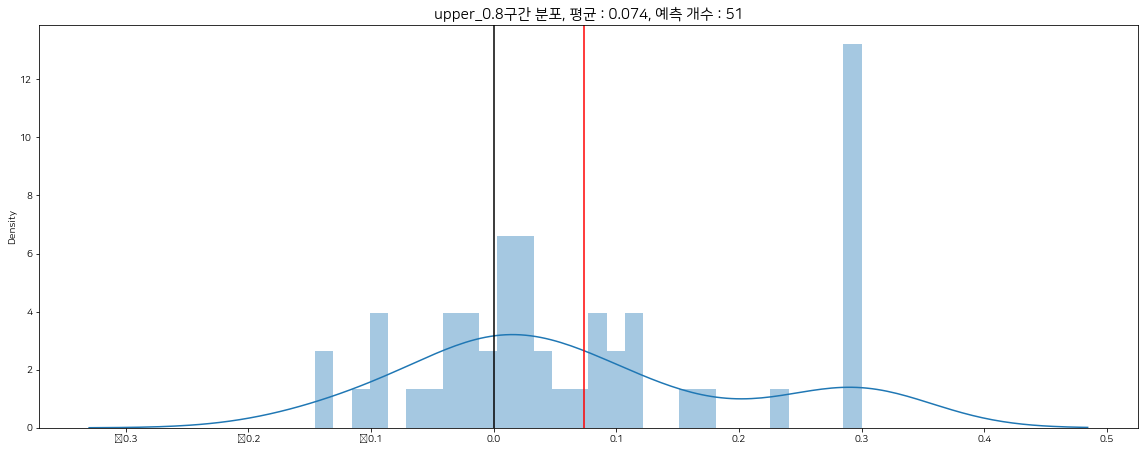

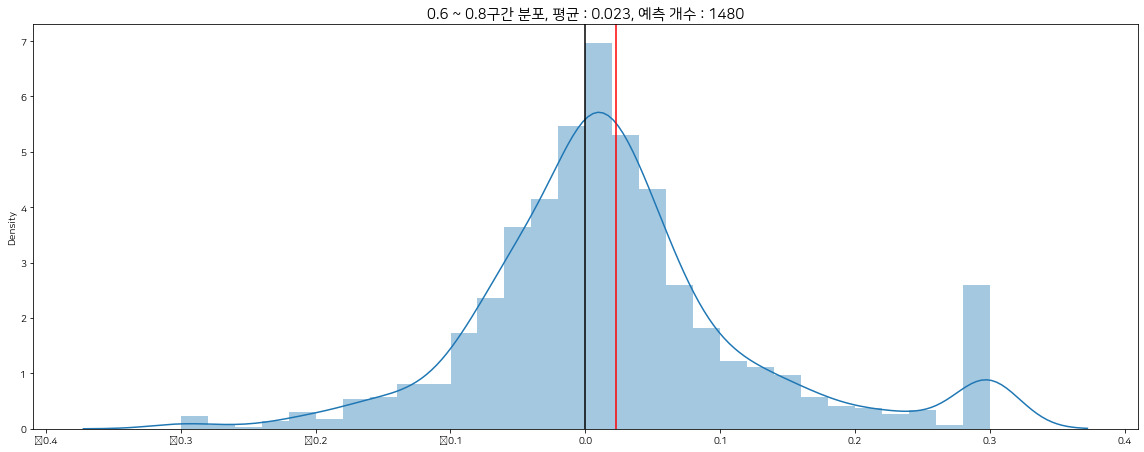

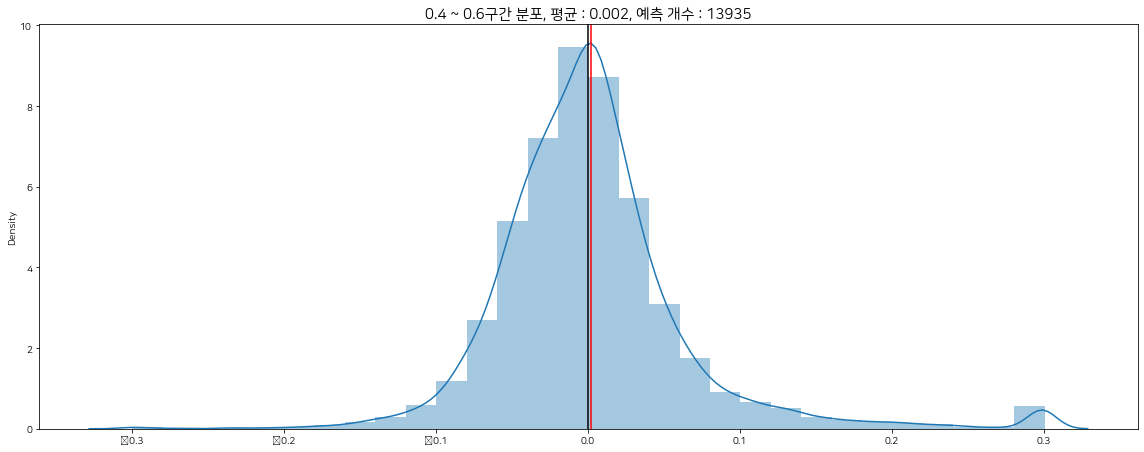

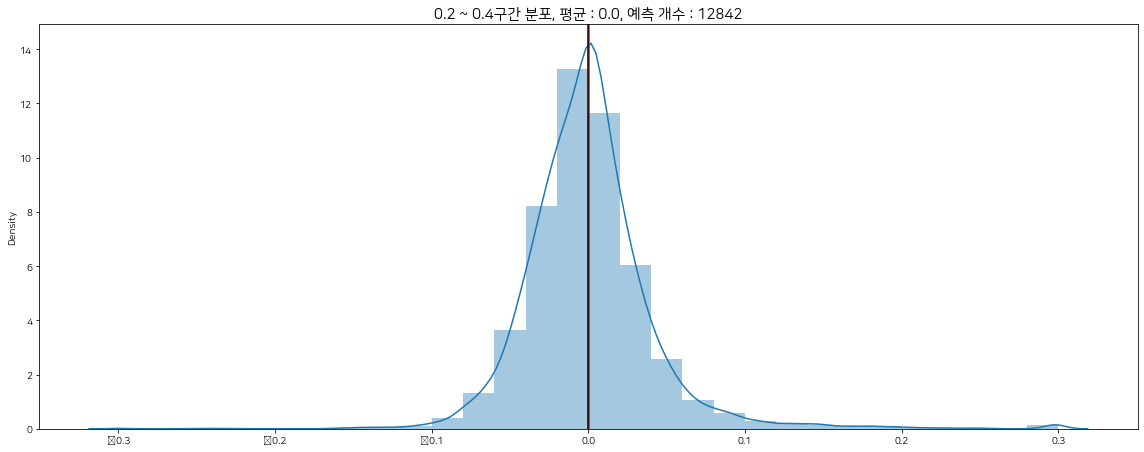

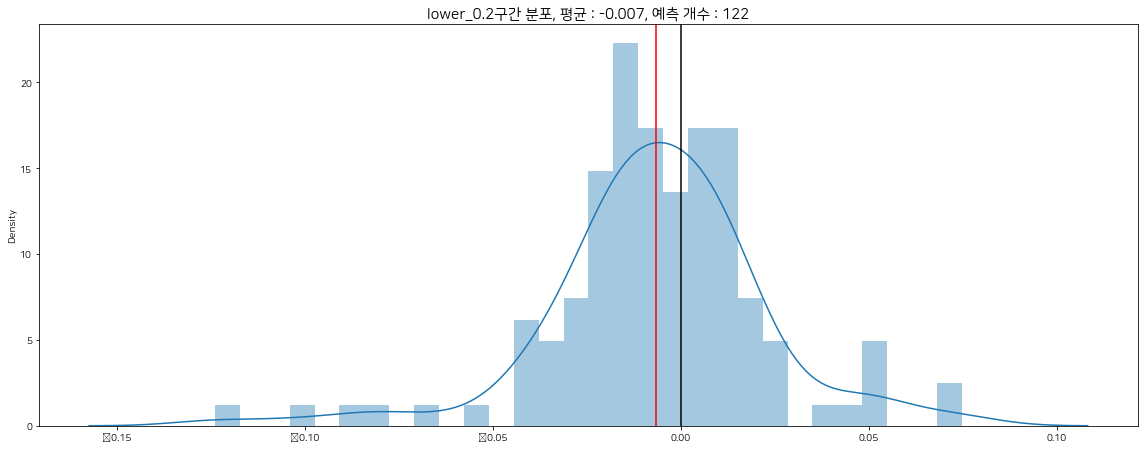

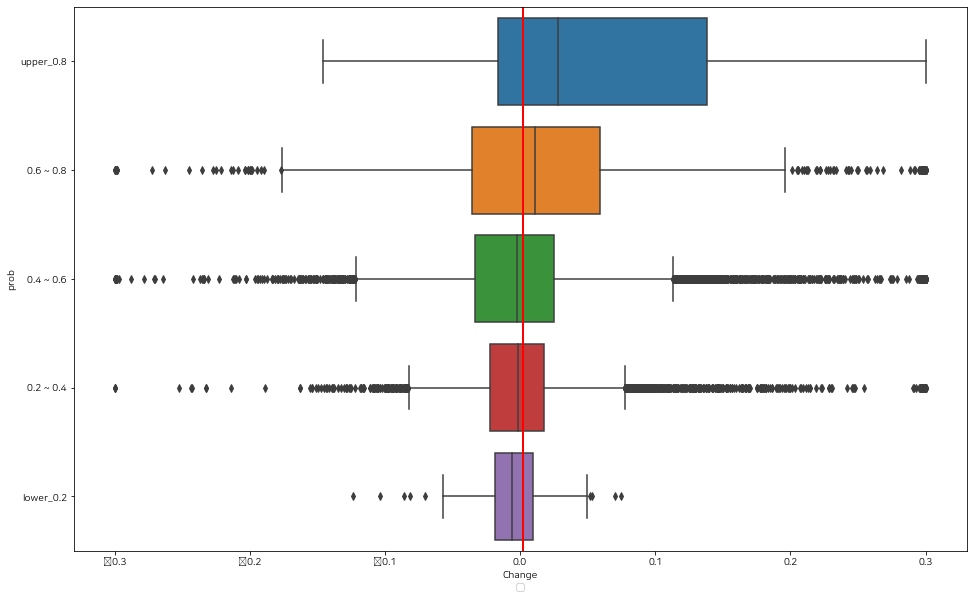

0.8 이상 구간의 정밀도 : 0.5490196078431373


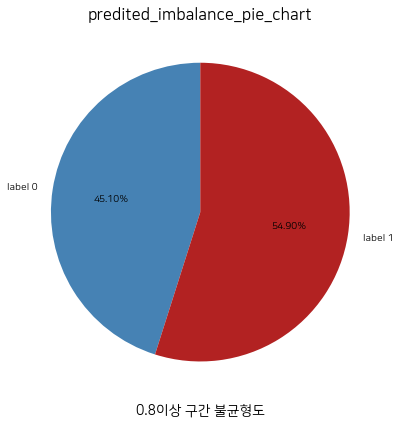

In [4]:
box_ax=plot_distribute(test_prob, test_change)

In [85]:
from simulator import simulator
simulater_result = simulator( date_code_lst, test_prob, fold )

시작 금액 : 100.0 만원

2021-01-04 : BUY 092300 -> 107주 구입, 매수 금액: 49.541만원
2021-01-04 : BUY 080580 -> 29주 구입, 매수 금액: 49.5175만원
2021-01-05 : SELL 092300 -> 매도 금액 : 52.8045만원, 전날 대비 상승률 0.06587473002159827:, 이익금 : 3.2635만원, 현재 자산 : 53.75만원
2021-01-05 : SELL 080580 -> 매도 금액 : 63.8만원, 전날 대비 상승률 0.28843338213762815:, 이익금 : 14.2825만원, 현재 자산 : 117.55만원

2021-01-06 : BUY 038070 -> 33주 구입, 매수 금액: 57.6378만원
2021-01-06 : BUY 001360 -> 54주 구입, 매수 금액: 58.05만원
2021-01-07 : SELL 038070 -> 매도 금액 : 56.8293만원, 전날 대비 상승률 -0.014027252948585867:, 이익금 : -0.8085만원, 현재 자산 : 58.69만원
2021-01-07 : SELL 001360 -> 매도 금액 : 63.45만원, 전날 대비 상승률 0.09302325581395343:, 이익금 : 5.4만원, 현재 자산 : 122.14만원

2021-01-07 : BUY 045340 -> 41주 구입, 매수 금액: 60.885만원
2021-01-07 : BUY 011080 -> 355주 구입, 매수 금액: 61.06만원
2021-01-08 : SELL 045340 -> 매도 금액 : 62.73만원, 전날 대비 상승률 0.030303030303030276:, 이익금 : 1.845만원, 현재 자산 : 62.92만원
2021-01-08 : SELL 011080 -> 매도 금액 : 61.5925만원, 전날 대비 상승률 0.008720930232558155:, 이익금 : 0.5325만원, 현재 자산 : 124.52만원

2021-01


2021-03-02 : BUY 047080 -> 173주 구입, 매수 금액: 84.943만원
2021-03-02 : BUY 024810 -> 371주 구입, 매수 금액: 84.959만원
2021-03-02 : BUY 065680 -> 33주 구입, 매수 금액: 82.83만원
2021-03-03 : SELL 047080 -> 매도 금액 : 95.496만원, 전날 대비 상승률 0.12423625254582493:, 이익금 : 10.553만원, 현재 자산 : 97.84만원
2021-03-03 : SELL 024810 -> 매도 금액 : 76.1663만원, 전날 대비 상승률 -0.10349344978165942:, 이익금 : -8.7927만원, 현재 자산 : 174.01만원
2021-03-03 : SELL 065680 -> 매도 금액 : 82.005만원, 전날 대비 상승률 -0.009960159362549792:, 이익금 : -0.825만원, 현재 자산 : 256.01만원

2021-03-04 : BUY 053290 -> 575주 구입, 매수 금액: 255.875만원
2021-03-05 : SELL 053290 -> 매도 금액 : 332.35만원, 전날 대비 상승률 0.29887640449438213:, 이익금 : 76.475만원, 현재 자산 : 332.49만원

2021-03-08 : BUY 053290 -> 442주 구입, 매수 금액: 331.942만원
2021-03-09 : SELL 053290 -> 매도 금액 : 345.644만원, 전날 대비 상승률 0.04127829560585883:, 이익금 : 13.702만원, 현재 자산 : 346.19만원

2021-03-09 : BUY 052460 -> 593주 구입, 매수 금액: 345.719만원
2021-03-10 : SELL 052460 -> 매도 금액 : 342.161만원, 전날 대비 상승률 -0.010291595197255532:, 이익금 : -3.558만원, 현재 자산 : 342.63만원

2021-03-


2021-05-25 : BUY 033540 -> 1487주 구입, 매수 금액: 410.412만원
2021-05-25 : BUY 101390 -> 260주 구입, 매수 금액: 410.098만원
2021-05-25 : BUY 032860 -> 602주 구입, 매수 금액: 409.962만원
2021-05-26 : SELL 033540 -> 매도 금액 : 415.6165만원, 전날 대비 상승률 0.0126811594202898:, 이익금 : 5.2045만원, 현재 자산 : 416.73만원
2021-05-26 : SELL 101390 -> 매도 금액 : 428.428만원, 전날 대비 상승률 0.04469663348760533:, 이익금 : 18.33만원, 현재 자산 : 845.16만원
2021-05-26 : SELL 032860 -> 매도 금액 : 532.77만원, 전날 대비 상승률 0.2995594713656389:, 이익금 : 122.808만원, 현재 자산 : 1377.93만원

2021-05-26 : BUY 032860 -> 1556주 구입, 매수 금액: 1377.06만원
2021-05-27 : SELL 032860 -> 매도 금액 : 1447.08만원, 전날 대비 상승률 0.05084745762711873:, 이익금 : 70.02만원, 현재 자산 : 1447.95만원

2021-05-31 : BUY 009620 -> 2413주 구입, 매수 금액: 723.9만원
2021-05-31 : BUY 136510 -> 3136주 구입, 매수 금액: 723.7888만원
2021-06-01 : SELL 009620 -> 매도 금액 : 784.225만원, 전날 대비 상승률 0.08333333333333326:, 이익금 : 60.325만원, 현재 자산 : 784.48만원
2021-06-01 : SELL 136510 -> 매도 금액 : 937.0368만원, 전날 대비 상승률 0.2946273830155979:, 이익금 : 213.248만원, 현재 자산 : 1721.52만원

20


2021-11-05 : BUY 126600 -> 4076주 구입, 매수 금액: 4850.44만원
2021-11-08 : SELL 126600 -> 매도 금액 : 4177.9만원, 전날 대비 상승률 -0.1386554621848739:, 이익금 : -672.54만원, 현재 자산 : 4177.99만원

2021-11-08 : BUY 038010 -> 2929주 구입, 매수 금액: 2088.377만원
2021-11-08 : BUY 136510 -> 556주 구입, 매수 금액: 2087.78만원
2021-11-09 : SELL 038010 -> 매도 금액 : 2712.254만원, 전날 대비 상승률 0.29873772791023834:, 이익금 : 623.877만원, 현재 자산 : 2714.09만원
2021-11-09 : SELL 136510 -> 매도 금액 : 2087.78만원, 전날 대비 상승률 0.0:, 이익금 : 0.0만원, 현재 자산 : 4801.87만원

2021-11-09 : BUY 038010 -> 2592주 구입, 매수 금액: 2400.192만원
2021-11-09 : BUY 011420 -> 6360주 구입, 매수 금액: 2400.9만원
2021-11-10 : SELL 038010 -> 매도 금액 : 2402.784만원, 전날 대비 상승률 0.001079913606911509:, 이익금 : 2.592만원, 현재 자산 : 2403.56만원
2021-11-10 : SELL 011420 -> 매도 금액 : 2191.02만원, 전날 대비 상승률 -0.0874172185430464:, 이익금 : -209.88만원, 현재 자산 : 4594.58만원

2021-11-10 : BUY 018700 -> 2900주 구입, 매수 금액: 1531.2만원
2021-11-10 : BUY 136510 -> 313주 구입, 매수 금액: 1527.44만원
2021-11-10 : BUY 134580 -> 3395주 구입, 매수 금액: 1531.145만원
2021-11-11 : SE

In [57]:
import yfinance as yf
kospi_df = yf.download('^KS11','2021-01-01',"2022-01-01").reset_index()
kospi__lst = kospi_df.values.tolist()

[*********************100%***********************]  1 of 1 completed


In [58]:


index_dict = {}
start_money = 1000000
money = start_money
for i,row in enumerate(kospi__lst):
    date = str(row[0]).split(" ")[0]
    kospi = row[4]
    
    index_dict[date] = [kospi, money]
    for sell_date, i_money in simulater_result:
        if date == sell_date :
            money = i_money
            break
            

In [47]:
pd.DataFrame(index_dict.values())

,0,1
0,2944.449951,1000000
1,2990.570068,1000000
2,2968.209961,1175460
3,3031.679932,1175460
4,3152.179932,1221375
...,...,...
243,3012.429932,49131628
244,2999.550049,49131628
245,3020.239990,49131628
246,2993.290039,49131628


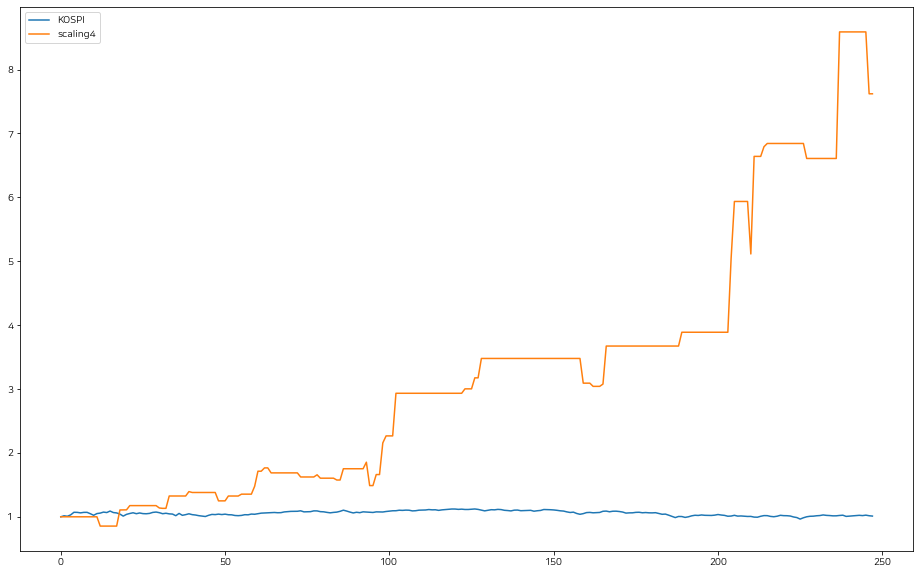

In [59]:
plt.figure(figsize=(16,10))
plt.plot(pd.DataFrame(index_dict.values())[0]/2944.449951, label='KOSPI')
plt.plot(pd.DataFrame(index_dict.values())[1]/1000000, label='scaling4')
plt.legend()

### 시뮬레이터 결과

<AxesSubplot:ylabel='Density'>

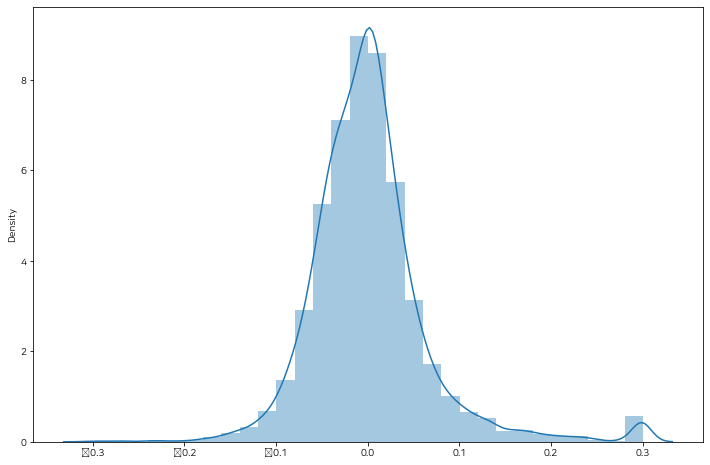

In [33]:
plt.figure(figsize=(12,8))
sns.distplot(sell_change_lst, bins = 30)

In [13]:
fold_1_earning_money_dict={}
fold_1_earning_money_dict['scaling1'] = 4513.58
fold_1_earning_money_dict['scaling2'] = 4893.48
fold_1_earning_money_dict['scaling3'] = 1248.30
fold_1_earning_money_dict['scaling4'] = 2905.88

In [14]:
# 6.4
fold_2_earning_money_dict={}
fold_2_earning_money_dict['scaling1'] = 154.19
fold_2_earning_money_dict['scaling2'] = 174.20
fold_2_earning_money_dict['scaling3'] = 409.73
fold_2_earning_money_dict['scaling4'] = 376.85

In [15]:
# 6.8
fold_2_earning_money_dict={}
fold_2_earning_money_dict['scaling1'] = 274.46
fold_2_earning_money_dict['scaling2'] = 476.75
fold_2_earning_money_dict['scaling3'] = 445.34
fold_2_earning_money_dict['scaling4'] = 543.35

In [16]:
# 8.2
fold_2_earning_money_dict={}
fold_2_earning_money_dict['scaling1'] = 274.46
fold_2_earning_money_dict['scaling2'] = 476.75
fold_2_earning_money_dict['scaling3'] = 445.34
fold_2_earning_money_dict['scaling4'] = 19079.45